In [12]:

from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.embeddings import Embedding
import nltk
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
import json
import pickle
import re
from nltk.corpus import stopwords

import numpy as np
from keras.layers import Dense, Activation, Dropout, Flatten, LSTM
from tensorflow.keras.optimizers import SGD, Adam
import random

from sklearn.model_selection import train_test_split

from numpy import array
from numpy import asarray
from numpy import zeros
from keras.preprocessing.text import Tokenizer
from nltk.tokenize import word_tokenize

import matplotlib.pyplot as plt

In [13]:
words=[]
classes = []
documents = []
ignore_words = ['?', '!']
data_file = open('D:/Coventry/Chatbot/Chatdata/intents.json').read()
intents = json.loads(data_file, strict=False)

In [16]:
for intent in intents['intents']:
    for pattern in intent['patterns']:

        #tokenize each word
        w = nltk.word_tokenize(pattern)
        words.extend(w)
        #add documents in the corpus
        documents.append((pattern, intent['tag']))
        # add to our classes list
        if intent['tag'] not in classes:
            classes.append(intent['tag'])

In [17]:
classes = sorted(list(set(classes)))

In [18]:
def clean_text(text_to_clean):
    res = text_to_clean.lower()
    res = re.sub(r"i'm", "i am", res)
    res = re.sub(r"he's", "he is", res)
    res = re.sub(r"she's", "she is", res)
    res = re.sub(r"it's", "it is", res)
    res = re.sub(r"that's", "that is", res)
    res = re.sub(r"what's", "what is", res)
    res = re.sub(r"where's", "where is", res)
    res = re.sub(r"how's", "how is", res)
    res = re.sub(r"\'ll", " will", res)
    res = re.sub(r"\'ve", " have", res)
    res = re.sub(r"\'re", " are", res)
    res = re.sub(r"\'d", " would", res)
    res = re.sub(r"\'re", " are", res)
    res = re.sub(r"won't", "will not", res)
    res = re.sub(r"can't", "cannot", res)
    res = re.sub(r"n't", " not", res)
    res = re.sub(r"n'", "ng", res)
    res = re.sub(r"'bout", "about", res)
    res = re.sub(r"'til", "until", res)
    res = re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,]", "", res)
    res = re.sub(r"[^\w\s]", "", res)
    return res

In [19]:
stop = stopwords.words('english')

# BOW

In [20]:
# lemmaztize and lower each word and remove duplicates
words = [lemmatizer.lemmatize(w.lower()) for w in words if w not in stop and ignore_words]
words = sorted(list(set(words)))
# sort classes
classes = sorted(list(set(classes)))
# documents = combination between patterns and intents
print (len(documents), "documents")
# classes = intents
print (len(classes), "classes")
# words = all words, vocabulary
print (len(words), "unique lemmatized words")

272 documents
49 classes
183 unique lemmatized words


In [21]:
# create our training data
training_bow = []
# create an empty array for our output
output_empty = [0] * len(classes)
# training set, bag of words for each sentence
for doc in documents:
    # initialize our bag of words
    bag = []
    # list of tokenized words for the pattern
    pattern_words = nltk.word_tokenize(clean_text(doc[0]))
    # lemmatize each word - create base word, in attempt to represent related words
    pattern_words = [lemmatizer.lemmatize(word.lower()) for word in pattern_words if word not in stop]
    # create our bag of words array with 1, if word match found in current pattern
    for w in words:
        bag.append(1) if w in pattern_words else bag.append(0)

    # output is a '0' for each tag and '1' for current tag (for each pattern)
    output_row = list(output_empty)
    output_row[classes.index(doc[1])] = 1

    training_bow.append([bag, output_row])

In [22]:
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning) 

In [23]:
# shuffle our features and turn into np.array
random.shuffle(training_bow)
training_bow = np.array(training_bow)
# create train and test lists. X - patterns, Y - intents
x = list(training_bow[:,0])
y = list(training_bow[:,1])
print("Training data created")

Training data created


In [29]:
print(len(x[0]))

183


In [25]:
pickle.dump(words,open('words.pkl','wb'))
pickle.dump(classes,open('classes.pkl','wb'))

# Train-Test Split

In [26]:
# split again, and we should see the same split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1)

In [27]:
model = Sequential()
model.add(Dense(128, input_shape=(len(x[0]),), activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(y[0]), activation='softmax'))

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               23552     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 49)                3185      
                                                                 
Total params: 34,993
Trainable params: 34,993
Non-trainable params: 0
_________________________________________________________________


In [30]:
sgd = SGD(learning_rate=0.01)

In [31]:
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

#fitting and saving the model
r = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=200, batch_size=5, verbose=1)

Epoch 1/200
38/38 [==============================] - 6s 34ms/step - loss: 3.9004 - accuracy: 0.0158 - val_loss: 3.8918 - val_accuracy: 0.0000e+00
Epoch 2/200
38/38 [==============================] - 0s 6ms/step - loss: 3.8845 - accuracy: 0.0316 - val_loss: 3.8874 - val_accuracy: 0.0000e+00
Epoch 3/200
38/38 [==============================] - 0s 4ms/step - loss: 3.8728 - accuracy: 0.0263 - val_loss: 3.8823 - val_accuracy: 0.0000e+00
Epoch 4/200
38/38 [==============================] - 0s 6ms/step - loss: 3.8674 - accuracy: 0.0211 - val_loss: 3.8769 - val_accuracy: 0.0000e+00
Epoch 5/200
38/38 [==============================] - 0s 4ms/step - loss: 3.8600 - accuracy: 0.0632 - val_loss: 3.8714 - val_accuracy: 0.0000e+00
Epoch 6/200
38/38 [==============================] - 0s 4ms/step - loss: 3.8508 - accuracy: 0.0316 - val_loss: 3.8665 - val_accuracy: 0.0122
Epoch 7/200
38/38 [==============================] - 0s 5ms/step - loss: 3.8403 - accuracy: 0.0526 - val_loss: 3.8613 - val_accuracy:

38/38 [==============================] - 0s 3ms/step - loss: 2.5372 - accuracy: 0.4632 - val_loss: 2.9353 - val_accuracy: 0.3415
Epoch 59/200
38/38 [==============================] - 0s 3ms/step - loss: 2.4589 - accuracy: 0.5053 - val_loss: 2.8953 - val_accuracy: 0.3537
Epoch 60/200
38/38 [==============================] - 0s 3ms/step - loss: 2.4216 - accuracy: 0.5211 - val_loss: 2.8575 - val_accuracy: 0.3659
Epoch 61/200
38/38 [==============================] - 0s 3ms/step - loss: 2.3906 - accuracy: 0.4842 - val_loss: 2.8165 - val_accuracy: 0.4024
Epoch 62/200
38/38 [==============================] - 0s 4ms/step - loss: 2.2571 - accuracy: 0.5632 - val_loss: 2.7741 - val_accuracy: 0.4024
Epoch 63/200
38/38 [==============================] - 0s 3ms/step - loss: 2.2964 - accuracy: 0.5105 - val_loss: 2.7357 - val_accuracy: 0.4146
Epoch 64/200
38/38 [==============================] - 0s 3ms/step - loss: 2.2746 - accuracy: 0.5053 - val_loss: 2.6885 - val_accuracy: 0.4268
Epoch 65/200
38/38 

Epoch 116/200
38/38 [==============================] - 0s 5ms/step - loss: 0.7892 - accuracy: 0.8526 - val_loss: 1.0758 - val_accuracy: 0.7805
Epoch 117/200
38/38 [==============================] - 0s 4ms/step - loss: 0.8422 - accuracy: 0.8579 - val_loss: 1.0548 - val_accuracy: 0.7927
Epoch 118/200
38/38 [==============================] - 0s 3ms/step - loss: 0.7862 - accuracy: 0.8474 - val_loss: 1.0416 - val_accuracy: 0.7927
Epoch 119/200
38/38 [==============================] - 0s 4ms/step - loss: 0.7426 - accuracy: 0.9053 - val_loss: 1.0302 - val_accuracy: 0.7805
Epoch 120/200
38/38 [==============================] - 0s 4ms/step - loss: 0.6845 - accuracy: 0.9053 - val_loss: 1.0137 - val_accuracy: 0.7805
Epoch 121/200
38/38 [==============================] - 0s 4ms/step - loss: 0.7414 - accuracy: 0.8737 - val_loss: 0.9951 - val_accuracy: 0.8171
Epoch 122/200
38/38 [==============================] - 0s 4ms/step - loss: 0.6792 - accuracy: 0.8842 - val_loss: 0.9817 - val_accuracy: 0.8049

38/38 [==============================] - 0s 4ms/step - loss: 0.3534 - accuracy: 0.9158 - val_loss: 0.6410 - val_accuracy: 0.8293
Epoch 174/200
38/38 [==============================] - 0s 3ms/step - loss: 0.3374 - accuracy: 0.9474 - val_loss: 0.6466 - val_accuracy: 0.8171
Epoch 175/200
38/38 [==============================] - 0s 4ms/step - loss: 0.3375 - accuracy: 0.9526 - val_loss: 0.6342 - val_accuracy: 0.8415
Epoch 176/200
38/38 [==============================] - 0s 4ms/step - loss: 0.2984 - accuracy: 0.9684 - val_loss: 0.6284 - val_accuracy: 0.8537
Epoch 177/200
38/38 [==============================] - 0s 3ms/step - loss: 0.3429 - accuracy: 0.9632 - val_loss: 0.6223 - val_accuracy: 0.8537
Epoch 178/200
38/38 [==============================] - 0s 3ms/step - loss: 0.2933 - accuracy: 0.9684 - val_loss: 0.6226 - val_accuracy: 0.8537
Epoch 179/200
38/38 [==============================] - 0s 4ms/step - loss: 0.2804 - accuracy: 0.9789 - val_loss: 0.6166 - val_accuracy: 0.8537
Epoch 180/200

In [32]:
model.save('chatbot_model_tt_sgd.h5', r)

In [33]:
# model accuracy on test dataset
score = model.evaluate(X_test,
                       y_test,
                       batch_size=5,
                       verbose=0)
print("\nTest accuracy: %.1f%%" % (100.0 * score[1]))


Test accuracy: 84.1%


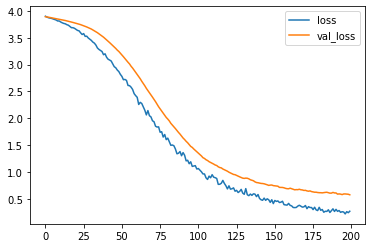

In [34]:
# Plot for loss

plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

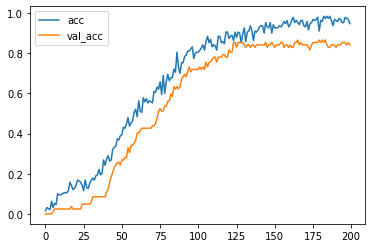

In [35]:
# plot for accuracy
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()

# Adam

In [36]:
adam = Adam(learning_rate=0.01)

In [37]:
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

#fitting and saving the model
r_2 = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=200, batch_size=5, verbose=1)

Epoch 1/200
38/38 [==============================] - 1s 12ms/step - loss: 0.7378 - accuracy: 0.7737 - val_loss: 1.0619 - val_accuracy: 0.7195
Epoch 2/200
38/38 [==============================] - 0s 4ms/step - loss: 0.2622 - accuracy: 0.9368 - val_loss: 0.6297 - val_accuracy: 0.8293
Epoch 3/200
38/38 [==============================] - 0s 4ms/step - loss: 0.1695 - accuracy: 0.9474 - val_loss: 0.6355 - val_accuracy: 0.8049
Epoch 4/200
38/38 [==============================] - 0s 5ms/step - loss: 0.0900 - accuracy: 0.9789 - val_loss: 0.5425 - val_accuracy: 0.8293
Epoch 5/200
38/38 [==============================] - 0s 4ms/step - loss: 0.1074 - accuracy: 0.9632 - val_loss: 0.6684 - val_accuracy: 0.7927
Epoch 6/200
38/38 [==============================] - 0s 4ms/step - loss: 0.0424 - accuracy: 1.0000 - val_loss: 0.6720 - val_accuracy: 0.8171
Epoch 7/200
38/38 [==============================] - 0s 4ms/step - loss: 0.0749 - accuracy: 0.9895 - val_loss: 0.6403 - val_accuracy: 0.8049
Epoch 8/200


Epoch 59/200
38/38 [==============================] - 0s 4ms/step - loss: 0.3301 - accuracy: 0.9526 - val_loss: 2.8601 - val_accuracy: 0.7805
Epoch 60/200
38/38 [==============================] - 0s 4ms/step - loss: 0.1414 - accuracy: 0.9579 - val_loss: 2.8548 - val_accuracy: 0.8049
Epoch 61/200
38/38 [==============================] - 0s 4ms/step - loss: 0.0995 - accuracy: 0.9842 - val_loss: 1.5992 - val_accuracy: 0.8171
Epoch 62/200
38/38 [==============================] - 0s 4ms/step - loss: 0.0349 - accuracy: 0.9895 - val_loss: 2.9672 - val_accuracy: 0.8171
Epoch 63/200
38/38 [==============================] - 0s 4ms/step - loss: 0.2687 - accuracy: 0.9579 - val_loss: 2.0218 - val_accuracy: 0.8537
Epoch 64/200
38/38 [==============================] - 0s 4ms/step - loss: 0.1144 - accuracy: 0.9684 - val_loss: 2.4765 - val_accuracy: 0.7561
Epoch 65/200
38/38 [==============================] - 0s 4ms/step - loss: 0.1450 - accuracy: 0.9684 - val_loss: 3.8249 - val_accuracy: 0.7561
Epoch 

38/38 [==============================] - 0s 4ms/step - loss: 0.0344 - accuracy: 0.9895 - val_loss: 3.6808 - val_accuracy: 0.7927
Epoch 117/200
38/38 [==============================] - 0s 3ms/step - loss: 0.0182 - accuracy: 0.9947 - val_loss: 3.7295 - val_accuracy: 0.7805
Epoch 118/200
38/38 [==============================] - 0s 4ms/step - loss: 0.0382 - accuracy: 0.9947 - val_loss: 3.6508 - val_accuracy: 0.7805
Epoch 119/200
38/38 [==============================] - 0s 4ms/step - loss: 0.0268 - accuracy: 0.9895 - val_loss: 4.0768 - val_accuracy: 0.7927
Epoch 120/200
38/38 [==============================] - 0s 4ms/step - loss: 0.1887 - accuracy: 0.9789 - val_loss: 4.0254 - val_accuracy: 0.7927
Epoch 121/200
38/38 [==============================] - 0s 5ms/step - loss: 0.0090 - accuracy: 0.9947 - val_loss: 3.9743 - val_accuracy: 0.7927
Epoch 122/200
38/38 [==============================] - 0s 5ms/step - loss: 0.1086 - accuracy: 0.9737 - val_loss: 3.5513 - val_accuracy: 0.7805
Epoch 123/200

38/38 [==============================] - 0s 4ms/step - loss: 0.2641 - accuracy: 0.9842 - val_loss: 5.2766 - val_accuracy: 0.7927
Epoch 174/200
38/38 [==============================] - 0s 5ms/step - loss: 0.2473 - accuracy: 0.9789 - val_loss: 5.8376 - val_accuracy: 0.8171
Epoch 175/200
38/38 [==============================] - 0s 4ms/step - loss: 0.4901 - accuracy: 0.9632 - val_loss: 5.1069 - val_accuracy: 0.8171
Epoch 176/200
38/38 [==============================] - 0s 4ms/step - loss: 0.3755 - accuracy: 0.9684 - val_loss: 4.7388 - val_accuracy: 0.7927
Epoch 177/200
38/38 [==============================] - 0s 3ms/step - loss: 0.1354 - accuracy: 0.9842 - val_loss: 4.8898 - val_accuracy: 0.8049
Epoch 178/200
38/38 [==============================] - 0s 3ms/step - loss: 0.0088 - accuracy: 0.9947 - val_loss: 4.6928 - val_accuracy: 0.8049
Epoch 179/200
38/38 [==============================] - 0s 4ms/step - loss: 0.3236 - accuracy: 0.9789 - val_loss: 4.1791 - val_accuracy: 0.8171
Epoch 180/200

In [38]:
# model accuracy on test dataset
score_2 = model.evaluate(X_test,
                       y_test,
                       batch_size=5,
                       verbose=0)
print("\nTest accuracy: %.1f%%" % (100.0 * score_2[1]))


Test accuracy: 81.7%


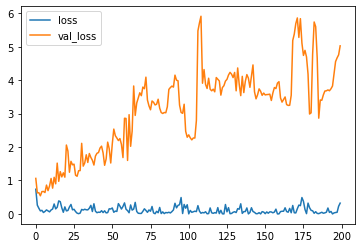

In [39]:
# Plot for loss
plt.plot(r_2.history['loss'], label='loss')
plt.plot(r_2.history['val_loss'], label='val_loss')
plt.legend()

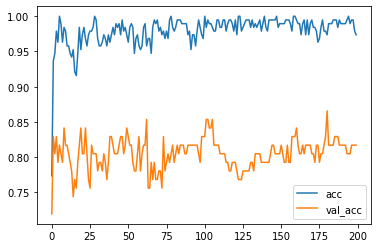

In [40]:
# plot for accuracy
plt.plot(r_2.history['accuracy'], label='acc')
plt.plot(r_2.history['val_accuracy'], label='val_acc')
plt.legend()

# K-fold

In [41]:
from sklearn.model_selection import StratifiedKFold, KFold
import numpy

# define 10-fold cross validation test harness
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
cvscores = []
X = np.array(x)
Y = np.array(y)

for train, test in kfold.split(X):
    print(len(X[train][0]))
    print(len(Y[train][0]))

  # create model
    model = Sequential()
    model.add(Dense(128, input_shape=(len(X[train][0]),), activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(len(Y[train][0]), activation='softmax'))

# Compile model. Stochastic gradient descent with Nesterov accelerated gradient gives good results for this model
    sgd = SGD(learning_rate=0.01)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
# Fit the model
    model.fit(X[train], Y[train], validation_data=(X[test], Y[test]), epochs=200, batch_size=5, verbose=0)
# evaluate the model
    scores = model.evaluate(X[test], Y[test], verbose=0)
    model.summary()
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))

183
49
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 128)               23552     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 49)                3185      
                                                                 
Total params: 34,993
Trainable params: 34,993
Non-trainable params: 0
_________________________________________________________________
accuracy: 90.91%
183
49
Model: "sequential_

In [42]:
# define 10-fold cross validation test harness
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
cvscores = []
X = np.array(x)
Y = np.array(y)

for train, test in kfold.split(X):
    print(len(X[train][0]))
    print(len(Y[train][0]))

  # create model
    model = Sequential()
    model.add(Dense(128, input_shape=(len(X[train][0]),), activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(len(Y[train][0]), activation='softmax'))

# Compile model. Stochastic gradient descent with Nesterov accelerated gradient gives good results for this model
    adam = Adam(learning_rate=0.01)
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
# Fit the model
    model.fit(X[train], Y[train], validation_data=(X[test], Y[test]), epochs=200, batch_size=5, verbose=0)
# evaluate the model
    scores = model.evaluate(X[test], Y[test], verbose=0)
    model.summary()
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))

183
49
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 128)               23552     
                                                                 
 dropout_12 (Dropout)        (None, 128)               0         
                                                                 
 dense_19 (Dense)            (None, 64)                8256      
                                                                 
 dropout_13 (Dropout)        (None, 64)                0         
                                                                 
 dense_20 (Dense)            (None, 49)                3185      
                                                                 
Total params: 34,993
Trainable params: 34,993
Non-trainable params: 0
_________________________________________________________________
accuracy: 87.27%
183
49
Model: "sequential_

# Glove

In [44]:
# create our training data
training = []

training_class = []
# create an empty array for our output
output_empty = [0] * len(classes)

for doc in documents:

    training.append(clean_text(doc[0]))

    # output is a '0' for each tag and '1' for current tag (for each pattern)
    output_row = list(output_empty)
    output_row[classes.index(doc[1])] = 1

    training_class.append(output_row)

print(len(training))
print(len(training_class))

272
272


In [45]:
training_class = np.array(training_class)
print(training_class[0])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0]


In [46]:
t = Tokenizer()
t.fit_on_texts(training)
vocab_size = len(t.word_index) + 1
print(vocab_size)

224


In [47]:
t.word_index

{'the': 1,
 'is': 2,
 'of': 3,
 'what': 4,
 'dean': 5,
 'engineering': 6,
 'to': 7,
 'contact': 8,
 'for': 9,
 'how': 10,
 'id': 11,
 'faculty': 12,
 'email': 13,
 'a': 14,
 'i': 15,
 'you': 16,
 'location': 17,
 'are': 18,
 'can': 19,
 'number': 20,
 'get': 21,
 'admission': 22,
 'classroom': 23,
 'transcript': 24,
 'where': 25,
 'it': 26,
 'fee': 27,
 'information': 28,
 'my': 29,
 'me': 30,
 'your': 31,
 'extension': 32,
 'and': 33,
 'do': 34,
 'possible': 35,
 'degree': 36,
 'clinic': 37,
 'health': 38,
 'duplicate': 39,
 'in': 40,
 'mechanical': 41,
 'facultys': 42,
 'civil': 43,
 'computer': 44,
 'science': 45,
 'electrical': 46,
 'biomedical': 47,
 'librarian': 48,
 'does': 49,
 'by': 50,
 'located': 51,
 'long': 52,
 'take': 53,
 'final': 54,
 'post': 55,
 'discipline': 56,
 'second': 57,
 'minimum': 58,
 'attendance': 59,
 'lecture': 60,
 'auditorium': 61,
 'building': 62,
 'n1': 63,
 'n2': 64,
 'n3': 65,
 'n4': 66,
 'pay': 67,
 'which': 68,
 'national': 69,
 'security': 70,
 

In [48]:
# integer encode the documents
encoded_docs = t.texts_to_sequences(training)

In [49]:
word_count = lambda sentence: len(word_tokenize(sentence))
longest_sentence = max(training, key=word_count)
length_long_sentence = len(word_tokenize(longest_sentence))
print(length_long_sentence)

15


In [50]:
# pad documents to a max length of 20 words
max_length = 20
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
padded_docs = np.array(padded_docs)

In [51]:
# load the whole embedding into memory
embeddings_index = dict()
f = open('D:/Coventry/Chatbot/Chatdata/glove/glove.6B.300d.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [52]:
# create a weight matrix for words in training docs
embedding_matrix = zeros((vocab_size, 300))
print(len(embedding_matrix[0]))
for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

300


In [53]:
print(embedding_matrix[1])

[ 4.65600006e-02  2.13180006e-01 -7.43639981e-03 -4.58539993e-01
 -3.56389992e-02  2.36430004e-01 -2.88360000e-01  2.15210006e-01
 -1.34859994e-01 -1.64129996e+00 -2.60910004e-01  3.24340016e-02
  5.66210002e-02 -4.32960019e-02 -2.16719992e-02  2.24759996e-01
 -7.51290023e-02 -6.70180023e-02 -1.42470002e-01  3.88250016e-02
 -1.89510003e-01  2.99769998e-01  3.93049985e-01  1.78870007e-01
 -1.73429996e-01 -2.11779997e-01  2.36169994e-01 -6.36809990e-02
 -4.23180014e-01 -1.16609998e-01  9.37540010e-02  1.72959998e-01
 -3.30729991e-01  4.91120011e-01 -6.89949989e-01 -9.24620032e-02
  2.47419998e-01 -1.79910004e-01  9.79079977e-02  8.31179991e-02
  1.52989998e-01 -2.72760004e-01 -3.89339998e-02  5.44529974e-01
  5.37370026e-01  2.91049987e-01 -7.35139987e-03  4.78800014e-02
 -4.07599986e-01 -2.67590005e-02  1.79189995e-01  1.09770000e-02
 -1.09630004e-01 -2.63949990e-01  7.39900023e-02  2.62360007e-01
 -1.50800005e-01  3.46230000e-01  2.57580012e-01  1.19709998e-01
 -3.71350013e-02 -7.15930

In [54]:
# split again, and we should see the same split
X_train_e, X_test_e, y_train_e, y_test_e = train_test_split(padded_docs, training_class, test_size=0.3, random_state=1)

In [55]:
# define model
model = Sequential()
e = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=20, trainable=False)
model.add(e)
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(training_class[0]), activation='softmax'))

# Compile model. Stochastic gradient descent with Nesterov accelerated gradient gives good results for this model
sgd = SGD(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [56]:
# summarize the model
print(model.summary())

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 300)           67200     
                                                                 
 flatten (Flatten)           (None, 6000)              0         
                                                                 
 dense_33 (Dense)            (None, 128)               768128    
                                                                 
 dropout_22 (Dropout)        (None, 128)               0         
                                                                 
 dense_34 (Dense)            (None, 64)                8256      
                                                                 
 dropout_23 (Dropout)        (None, 64)                0         
                                                                 
 dense_35 (Dense)            (None, 49)              

In [57]:
r_g = model.fit(X_train_e, y_train_e, validation_data=(X_test_e, y_test_e), epochs=200, batch_size=5, verbose=1)

Epoch 1/200
38/38 [==============================] - 1s 14ms/step - loss: 3.9168 - accuracy: 0.0053 - val_loss: 3.8814 - val_accuracy: 0.0610
Epoch 2/200
38/38 [==============================] - 0s 8ms/step - loss: 3.7908 - accuracy: 0.0842 - val_loss: 3.8369 - val_accuracy: 0.0610
Epoch 3/200
38/38 [==============================] - 0s 8ms/step - loss: 3.6470 - accuracy: 0.1526 - val_loss: 3.7908 - val_accuracy: 0.1098
Epoch 4/200
38/38 [==============================] - 0s 8ms/step - loss: 3.4222 - accuracy: 0.2105 - val_loss: 3.7542 - val_accuracy: 0.1220
Epoch 5/200
38/38 [==============================] - 0s 8ms/step - loss: 3.2916 - accuracy: 0.2895 - val_loss: 3.7221 - val_accuracy: 0.1341
Epoch 6/200
38/38 [==============================] - 0s 8ms/step - loss: 3.0832 - accuracy: 0.3316 - val_loss: 3.6524 - val_accuracy: 0.1585
Epoch 7/200
38/38 [==============================] - 0s 8ms/step - loss: 2.9359 - accuracy: 0.3579 - val_loss: 3.5780 - val_accuracy: 0.1707
Epoch 8/200


Epoch 59/200
38/38 [==============================] - 0s 7ms/step - loss: 0.1775 - accuracy: 0.9684 - val_loss: 2.8198 - val_accuracy: 0.3415
Epoch 60/200
38/38 [==============================] - 0s 7ms/step - loss: 0.2090 - accuracy: 0.9684 - val_loss: 2.8088 - val_accuracy: 0.3537
Epoch 61/200
38/38 [==============================] - 0s 7ms/step - loss: 0.2119 - accuracy: 0.9842 - val_loss: 2.8169 - val_accuracy: 0.3537
Epoch 62/200
38/38 [==============================] - 0s 7ms/step - loss: 0.1974 - accuracy: 0.9684 - val_loss: 2.8478 - val_accuracy: 0.3415
Epoch 63/200
38/38 [==============================] - 0s 8ms/step - loss: 0.2163 - accuracy: 0.9579 - val_loss: 2.9246 - val_accuracy: 0.3415
Epoch 64/200
38/38 [==============================] - 0s 7ms/step - loss: 0.1895 - accuracy: 0.9632 - val_loss: 2.8172 - val_accuracy: 0.3659
Epoch 65/200
38/38 [==============================] - 0s 7ms/step - loss: 0.2004 - accuracy: 0.9737 - val_loss: 2.7907 - val_accuracy: 0.3293
Epoch 

38/38 [==============================] - 0s 7ms/step - loss: 0.0515 - accuracy: 1.0000 - val_loss: 3.0962 - val_accuracy: 0.3537
Epoch 117/200
38/38 [==============================] - 0s 7ms/step - loss: 0.0742 - accuracy: 0.9789 - val_loss: 3.1294 - val_accuracy: 0.3537
Epoch 118/200
38/38 [==============================] - 0s 7ms/step - loss: 0.0639 - accuracy: 1.0000 - val_loss: 3.1202 - val_accuracy: 0.3537
Epoch 119/200
38/38 [==============================] - 0s 7ms/step - loss: 0.0593 - accuracy: 1.0000 - val_loss: 3.0661 - val_accuracy: 0.3415
Epoch 120/200
38/38 [==============================] - 0s 7ms/step - loss: 0.0652 - accuracy: 1.0000 - val_loss: 3.1377 - val_accuracy: 0.3537
Epoch 121/200
38/38 [==============================] - 0s 7ms/step - loss: 0.0749 - accuracy: 0.9842 - val_loss: 3.1441 - val_accuracy: 0.3415
Epoch 122/200
38/38 [==============================] - 0s 7ms/step - loss: 0.0445 - accuracy: 0.9947 - val_loss: 3.1524 - val_accuracy: 0.3415
Epoch 123/200

38/38 [==============================] - 0s 7ms/step - loss: 0.0243 - accuracy: 1.0000 - val_loss: 3.2034 - val_accuracy: 0.3659
Epoch 174/200
38/38 [==============================] - 0s 7ms/step - loss: 0.0235 - accuracy: 1.0000 - val_loss: 3.2183 - val_accuracy: 0.3659
Epoch 175/200
38/38 [==============================] - 0s 7ms/step - loss: 0.0353 - accuracy: 1.0000 - val_loss: 3.2302 - val_accuracy: 0.3537
Epoch 176/200
38/38 [==============================] - 0s 7ms/step - loss: 0.0300 - accuracy: 1.0000 - val_loss: 3.2730 - val_accuracy: 0.3659
Epoch 177/200
38/38 [==============================] - 0s 7ms/step - loss: 0.0304 - accuracy: 1.0000 - val_loss: 3.2782 - val_accuracy: 0.3780
Epoch 178/200
38/38 [==============================] - 0s 7ms/step - loss: 0.0459 - accuracy: 0.9842 - val_loss: 3.2732 - val_accuracy: 0.3780
Epoch 179/200
38/38 [==============================] - 0s 7ms/step - loss: 0.0392 - accuracy: 0.9895 - val_loss: 3.2799 - val_accuracy: 0.3659
Epoch 180/200

In [58]:
# model accuracy on test dataset
score_g = model.evaluate(X_test_e,
                       y_test_e,
                       batch_size=5,
                       verbose=0)
print("\nTest accuracy: %.1f%%" % (100.0 * score_g[1]))


Test accuracy: 40.2%


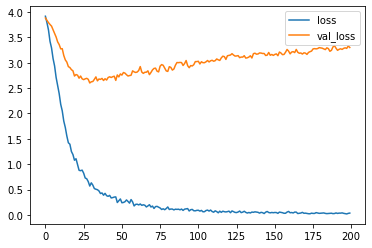

In [59]:
# Plot for loss
plt.plot(r_g.history['loss'], label='loss')
plt.plot(r_g.history['val_loss'], label='val_loss')
plt.legend()

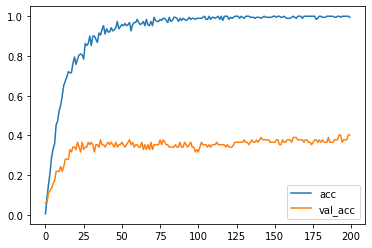

In [60]:
# plot for accuracy
plt.plot(r_g.history['accuracy'], label='acc')
plt.plot(r_g.history['val_accuracy'], label='val_acc')
plt.legend()

In [61]:
# CV

In [62]:
cvscores_g = []
X = padded_docs
Y = training_class

In [63]:
for train, test in kfold.split(X):
    print(len(X[train]))
    print(len(Y[train][0]))

  # create model
    model = Sequential()
    e = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=20, trainable=False)
    model.add(e)
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(len(training_class[0]), activation='softmax'))

# Compile model. Stochastic gradient descent with Nesterov accelerated gradient gives good results for this model
    sgd = SGD(lr=0.01)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
# Fit the model
    model.fit(X[train], Y[train], epochs=200, batch_size=5, verbose=0)
# evaluate the model
    scores = model.evaluate(X[test], Y[test], verbose=0)
    model.summary()
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores_g.append(scores[1] * 100)
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores_g), numpy.std(cvscores_g)))

217
49


C:\Users\Johnson\anaconda3\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 20, 300)           67200     
                                                                 
 flatten_1 (Flatten)         (None, 6000)              0         
                                                                 
 dense_36 (Dense)            (None, 128)               768128    
                                                                 
 dropout_24 (Dropout)        (None, 128)               0         
                                                                 
 dense_37 (Dense)            (None, 64)                8256      
                                                                 
 dropout_25 (Dropout)        (None, 64)                0         
                                                                 
 dense_38 (Dense)            (None, 49)              

Total params: 846,769
Trainable params: 779,569
Non-trainable params: 67,200
_________________________________________________________________
accuracy: 51.85%
47.76% (+/- 6.83%)


In [43]:
# Adam

In [96]:
# define model
model = Sequential()
e = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=20, trainable=False)
model.add(e)
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(training_class[0]), activation='softmax'))

# Compile model. Stochastic gradient descent with Nesterov accelerated gradient gives good results for this model
adam = Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [97]:
r_a = model.fit(X_train_e, y_train_e, validation_data=(X_test_e, y_test_e), epochs=200, batch_size=5, verbose=1)

Epoch 1/200
38/38 [==============================] - 1s 15ms/step - loss: 4.7285 - accuracy: 0.0526 - val_loss: 3.9283 - val_accuracy: 0.0732
Epoch 2/200
38/38 [==============================] - 0s 10ms/step - loss: 3.5194 - accuracy: 0.1421 - val_loss: 3.9552 - val_accuracy: 0.0854
Epoch 3/200
38/38 [==============================] - 0s 11ms/step - loss: 3.3163 - accuracy: 0.2211 - val_loss: 3.8386 - val_accuracy: 0.0976
Epoch 4/200
38/38 [==============================] - 1s 13ms/step - loss: 3.0895 - accuracy: 0.2684 - val_loss: 3.7548 - val_accuracy: 0.1341
Epoch 5/200
38/38 [==============================] - 0s 13ms/step - loss: 3.1198 - accuracy: 0.2789 - val_loss: 3.8772 - val_accuracy: 0.1098
Epoch 6/200
38/38 [==============================] - 1s 13ms/step - loss: 2.6864 - accuracy: 0.3316 - val_loss: 3.2745 - val_accuracy: 0.1220
Epoch 7/200
38/38 [==============================] - 0s 11ms/step - loss: 2.9236 - accuracy: 0.3368 - val_loss: 3.4922 - val_accuracy: 0.1951
Epoch 

38/38 [==============================] - 0s 11ms/step - loss: 2.4839 - accuracy: 0.3579 - val_loss: 5.0864 - val_accuracy: 0.1463
Epoch 59/200
38/38 [==============================] - 0s 10ms/step - loss: 2.5753 - accuracy: 0.3421 - val_loss: 4.7455 - val_accuracy: 0.1220
Epoch 60/200
38/38 [==============================] - 0s 12ms/step - loss: 2.5374 - accuracy: 0.3474 - val_loss: 4.6305 - val_accuracy: 0.1463
Epoch 61/200
38/38 [==============================] - 0s 12ms/step - loss: 2.4586 - accuracy: 0.3316 - val_loss: 4.7950 - val_accuracy: 0.1098
Epoch 62/200
38/38 [==============================] - 0s 11ms/step - loss: 2.4707 - accuracy: 0.3211 - val_loss: 4.9246 - val_accuracy: 0.1707
Epoch 63/200
38/38 [==============================] - 0s 12ms/step - loss: 2.3545 - accuracy: 0.3368 - val_loss: 5.2934 - val_accuracy: 0.1951
Epoch 64/200
38/38 [==============================] - 0s 12ms/step - loss: 2.8966 - accuracy: 0.3579 - val_loss: 5.5045 - val_accuracy: 0.1829
Epoch 65/200

38/38 [==============================] - 0s 9ms/step - loss: 3.1737 - accuracy: 0.3053 - val_loss: 4.3216 - val_accuracy: 0.0854
Epoch 116/200
38/38 [==============================] - 0s 9ms/step - loss: 2.8147 - accuracy: 0.2526 - val_loss: 4.3398 - val_accuracy: 0.0610
Epoch 117/200
38/38 [==============================] - 0s 9ms/step - loss: 2.8479 - accuracy: 0.2789 - val_loss: 4.3254 - val_accuracy: 0.0732
Epoch 118/200
38/38 [==============================] - 0s 9ms/step - loss: 2.6036 - accuracy: 0.3105 - val_loss: 4.3338 - val_accuracy: 0.0732
Epoch 119/200
38/38 [==============================] - 0s 9ms/step - loss: 2.6118 - accuracy: 0.3000 - val_loss: 4.4230 - val_accuracy: 0.0732
Epoch 120/200
38/38 [==============================] - 0s 10ms/step - loss: 2.8229 - accuracy: 0.2789 - val_loss: 4.4459 - val_accuracy: 0.0854
Epoch 121/200
38/38 [==============================] - 0s 9ms/step - loss: 2.7352 - accuracy: 0.2789 - val_loss: 4.3761 - val_accuracy: 0.0732
Epoch 122/20

38/38 [==============================] - 0s 9ms/step - loss: 2.9502 - accuracy: 0.2842 - val_loss: 7.5875 - val_accuracy: 0.0732
Epoch 173/200
38/38 [==============================] - 0s 8ms/step - loss: 2.9017 - accuracy: 0.2474 - val_loss: 7.7213 - val_accuracy: 0.0732
Epoch 174/200
38/38 [==============================] - 0s 9ms/step - loss: 2.9711 - accuracy: 0.2842 - val_loss: 7.9878 - val_accuracy: 0.0732
Epoch 175/200
38/38 [==============================] - 0s 9ms/step - loss: 2.9738 - accuracy: 0.3000 - val_loss: 7.4511 - val_accuracy: 0.0976
Epoch 176/200
38/38 [==============================] - 0s 8ms/step - loss: 2.8166 - accuracy: 0.2789 - val_loss: 6.9937 - val_accuracy: 0.0610
Epoch 177/200
38/38 [==============================] - 0s 9ms/step - loss: 2.7652 - accuracy: 0.2947 - val_loss: 7.2872 - val_accuracy: 0.0488
Epoch 178/200
38/38 [==============================] - 0s 9ms/step - loss: 2.5041 - accuracy: 0.3053 - val_loss: 7.1600 - val_accuracy: 0.0732
Epoch 179/200

In [98]:
# model accuracy on test dataset
score_a = model.evaluate(X_test_e,
                       y_test_e,
                       batch_size=5,
                       verbose=0)
print("\nTest accuracy: %.1f%%" % (100.0 * score_a[1]))


Test accuracy: 7.3%


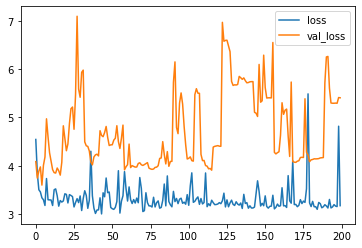

In [67]:
# Plot for loss
plt.plot(r_a.history['loss'], label='loss')
plt.plot(r_a.history['val_loss'], label='val_loss')
plt.legend()

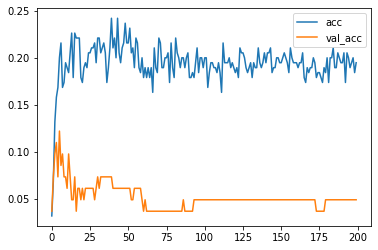

In [68]:
# plot for accuracy
plt.plot(r_a.history['accuracy'], label='acc')
plt.plot(r_a.history['val_accuracy'], label='val_acc')
plt.legend()

In [69]:
for train, test in kfold.split(X):

  # create model
    model = Sequential()
    e = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=20, trainable=False)
    model.add(e)
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(len(training_class[0]), activation='softmax'))

# Compile model. Stochastic gradient descent with Nesterov accelerated gradient gives good results for this model
    adam = Adam(learning_rate=0.01)
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
# Fit the model
    model.fit(X[train], Y[train], epochs=200, batch_size=5, verbose=0)
# evaluate the model
    scores = model.evaluate(X[test], Y[test], verbose=0)
    model.summary()
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores_g.append(scores[1] * 100)
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores_g), numpy.std(cvscores_g)))

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 20, 300)           67200     
                                                                 
 flatten_7 (Flatten)         (None, 6000)              0         
                                                                 
 dense_54 (Dense)            (None, 128)               768128    
                                                                 
 dropout_36 (Dropout)        (None, 128)               0         
                                                                 
 dense_55 (Dense)            (None, 64)                8256      
                                                                 
 dropout_37 (Dropout)        (None, 64)                0         
                                                                 
 dense_56 (Dense)            (None, 49)              

# Fasttext

In [70]:
# load the whole embedding into memory
embeddings_index_fast = dict()
f = open('D:/Coventry/Chatbot/Chatdata/fast/wiki-news-300d-1M.vec', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = asarray(values[1:], dtype='float32')
    embeddings_index_fast[word] = coefs
f.close()

print('Loaded %s word vectors.' % len(embeddings_index_fast))

Loaded 999995 word vectors.


In [71]:
# create a weight matrix for words in training docs
embedding_matrix_fast = zeros((vocab_size, 300))
print(len(embedding_matrix[0]))
for word, i in t.word_index.items():
    embedding_vector = embeddings_index_fast.get(word)
    if embedding_vector is not None:
        embedding_matrix_fast[i] = embedding_vector

300


In [72]:
# define model
model = Sequential()
e = Embedding(vocab_size, 300, weights=[embedding_matrix_fast], input_length=20, trainable=False)
model.add(e)
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(training_class[0]), activation='softmax'))

# Compile model. Stochastic gradient descent with Nesterov accelerated gradient gives good results for this model
sgd = SGD(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [73]:
# summarize the model
print(model.summary())

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 20, 300)           67200     
                                                                 
 flatten_12 (Flatten)        (None, 6000)              0         
                                                                 
 dense_69 (Dense)            (None, 128)               768128    
                                                                 
 dropout_46 (Dropout)        (None, 128)               0         
                                                                 
 dense_70 (Dense)            (None, 64)                8256      
                                                                 
 dropout_47 (Dropout)        (None, 64)                0         
                                                                 
 dense_71 (Dense)            (None, 49)              

In [74]:
r_f = model.fit(X_train_e, y_train_e, validation_data=(X_test_e, y_test_e), epochs=200, batch_size=5, verbose=1)

Epoch 1/200
38/38 [==============================] - 1s 15ms/step - loss: 3.8895 - accuracy: 0.0316 - val_loss: 3.8962 - val_accuracy: 0.0366
Epoch 2/200
38/38 [==============================] - 0s 8ms/step - loss: 3.8782 - accuracy: 0.0474 - val_loss: 3.8929 - val_accuracy: 0.0610
Epoch 3/200
38/38 [==============================] - 0s 8ms/step - loss: 3.8565 - accuracy: 0.0632 - val_loss: 3.8908 - val_accuracy: 0.0610
Epoch 4/200
38/38 [==============================] - 0s 10ms/step - loss: 3.8358 - accuracy: 0.1000 - val_loss: 3.8898 - val_accuracy: 0.0610
Epoch 5/200
38/38 [==============================] - 0s 7ms/step - loss: 3.8277 - accuracy: 0.1000 - val_loss: 3.8872 - val_accuracy: 0.0488
Epoch 6/200
38/38 [==============================] - 0s 7ms/step - loss: 3.8114 - accuracy: 0.0895 - val_loss: 3.8835 - val_accuracy: 0.0244
Epoch 7/200
38/38 [==============================] - 0s 8ms/step - loss: 3.7870 - accuracy: 0.1263 - val_loss: 3.8776 - val_accuracy: 0.0366
Epoch 8/200

Epoch 59/200
38/38 [==============================] - 0s 7ms/step - loss: 1.2788 - accuracy: 0.7789 - val_loss: 2.6294 - val_accuracy: 0.2927
Epoch 60/200
38/38 [==============================] - 0s 7ms/step - loss: 1.2453 - accuracy: 0.7211 - val_loss: 2.6094 - val_accuracy: 0.3049
Epoch 61/200
38/38 [==============================] - 0s 7ms/step - loss: 1.2156 - accuracy: 0.7526 - val_loss: 2.5977 - val_accuracy: 0.2927
Epoch 62/200
38/38 [==============================] - 0s 7ms/step - loss: 1.2222 - accuracy: 0.7105 - val_loss: 2.5780 - val_accuracy: 0.3293
Epoch 63/200
38/38 [==============================] - 0s 7ms/step - loss: 1.1751 - accuracy: 0.7474 - val_loss: 2.5604 - val_accuracy: 0.3171
Epoch 64/200
38/38 [==============================] - 0s 7ms/step - loss: 1.1136 - accuracy: 0.7368 - val_loss: 2.5393 - val_accuracy: 0.3049
Epoch 65/200
38/38 [==============================] - 0s 7ms/step - loss: 1.1832 - accuracy: 0.6895 - val_loss: 2.5281 - val_accuracy: 0.3293
Epoch 

38/38 [==============================] - 0s 7ms/step - loss: 0.4451 - accuracy: 0.9053 - val_loss: 2.3255 - val_accuracy: 0.3659
Epoch 117/200
38/38 [==============================] - 0s 7ms/step - loss: 0.4019 - accuracy: 0.9211 - val_loss: 2.3236 - val_accuracy: 0.3659
Epoch 118/200
38/38 [==============================] - 0s 7ms/step - loss: 0.4628 - accuracy: 0.8842 - val_loss: 2.3415 - val_accuracy: 0.3659
Epoch 119/200
38/38 [==============================] - 0s 7ms/step - loss: 0.4221 - accuracy: 0.8895 - val_loss: 2.3494 - val_accuracy: 0.3659
Epoch 120/200
38/38 [==============================] - 0s 7ms/step - loss: 0.3844 - accuracy: 0.9211 - val_loss: 2.3276 - val_accuracy: 0.3780
Epoch 121/200
38/38 [==============================] - 0s 7ms/step - loss: 0.4208 - accuracy: 0.9158 - val_loss: 2.3499 - val_accuracy: 0.3537
Epoch 122/200
38/38 [==============================] - 0s 7ms/step - loss: 0.4396 - accuracy: 0.9000 - val_loss: 2.3404 - val_accuracy: 0.3659
Epoch 123/200

38/38 [==============================] - 0s 8ms/step - loss: 0.2234 - accuracy: 0.9737 - val_loss: 2.4207 - val_accuracy: 0.3659
Epoch 174/200
38/38 [==============================] - 0s 7ms/step - loss: 0.1939 - accuracy: 0.9737 - val_loss: 2.4447 - val_accuracy: 0.3415
Epoch 175/200
38/38 [==============================] - 0s 8ms/step - loss: 0.1971 - accuracy: 0.9632 - val_loss: 2.4383 - val_accuracy: 0.3659
Epoch 176/200
38/38 [==============================] - 0s 7ms/step - loss: 0.1844 - accuracy: 0.9684 - val_loss: 2.4485 - val_accuracy: 0.3659
Epoch 177/200
38/38 [==============================] - 0s 8ms/step - loss: 0.2266 - accuracy: 0.9474 - val_loss: 2.4507 - val_accuracy: 0.3659
Epoch 178/200
38/38 [==============================] - 0s 8ms/step - loss: 0.1588 - accuracy: 0.9895 - val_loss: 2.4486 - val_accuracy: 0.3659
Epoch 179/200
38/38 [==============================] - 0s 8ms/step - loss: 0.2375 - accuracy: 0.9579 - val_loss: 2.4046 - val_accuracy: 0.3659
Epoch 180/200

In [75]:
# model accuracy on test dataset
score_f = model.evaluate(X_test_e,
                       y_test_e,
                       batch_size=5,
                       verbose=0)
print("\nTest accuracy: %.1f%%" % (100.0 * score_f[1]))


Test accuracy: 36.6%


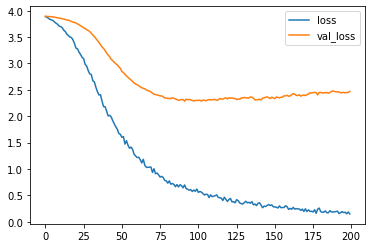

In [76]:
# Plot for loss

plt.plot(r_f.history['loss'], label='loss')
plt.plot(r_f.history['val_loss'], label='val_loss')
plt.legend()

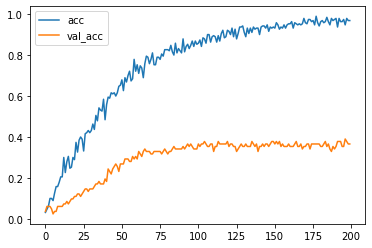

In [77]:
# plot for accuracy
plt.plot(r_f.history['accuracy'], label='acc')
plt.plot(r_f.history['val_accuracy'], label='val_acc')
plt.legend()

In [78]:
cvscores_fast = []

In [79]:
for train, test in kfold.split(X):
    print(len(X[train]))
    print(len(Y[train][0]))

  # create model
    model = Sequential()
    e = Embedding(vocab_size, 300, weights=[embedding_matrix_fast], input_length=20, trainable=False)
    model.add(e)
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(len(training_class[0]), activation='softmax'))

# Compile model. Stochastic gradient descent with Nesterov accelerated gradient gives good results for this model
    sgd = SGD(lr=0.01)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
# Fit the model
    model.fit(X[train], Y[train], epochs=200, batch_size=5, verbose=0)
# evaluate the model
    scores = model.evaluate(X[test], Y[test], verbose=0)
    model.summary()
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores_fast.append(scores[1] * 100)
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores_fast), numpy.std(cvscores_fast)))

217
49
Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 20, 300)           67200     
                                                                 
 flatten_13 (Flatten)        (None, 6000)              0         
                                                                 
 dense_72 (Dense)            (None, 128)               768128    
                                                                 
 dropout_48 (Dropout)        (None, 128)               0         
                                                                 
 dense_73 (Dense)            (None, 64)                8256      
                                                                 
 dropout_49 (Dropout)        (None, 64)                0         
                                                                 
 dense_74 (Dense)            (None, 49)       

In [80]:
# Adam

In [88]:
# define model
model = Sequential()
e = Embedding(vocab_size, 300, weights=[embedding_matrix_fast], input_length=20, trainable=False)
model.add(e)
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(training_class[0]), activation='softmax'))

# Compile model. Stochastic gradient descent with Nesterov accelerated gradient gives good results for this model
adam = Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [89]:
r_f_2 = model.fit(X_train_e, y_train_e, validation_data=(X_test_e, y_test_e), epochs=200, batch_size=5, verbose=1)

Epoch 1/200
38/38 [==============================] - 1s 15ms/step - loss: 4.0856 - accuracy: 0.0158 - val_loss: 3.7280 - val_accuracy: 0.1098
Epoch 2/200
38/38 [==============================] - 0s 9ms/step - loss: 3.2760 - accuracy: 0.1947 - val_loss: 3.2892 - val_accuracy: 0.1220
Epoch 3/200
38/38 [==============================] - 0s 9ms/step - loss: 2.6177 - accuracy: 0.2947 - val_loss: 3.1541 - val_accuracy: 0.1707
Epoch 4/200
38/38 [==============================] - 0s 10ms/step - loss: 2.0728 - accuracy: 0.3632 - val_loss: 2.8646 - val_accuracy: 0.2073
Epoch 5/200
38/38 [==============================] - 0s 11ms/step - loss: 1.8049 - accuracy: 0.4895 - val_loss: 2.9420 - val_accuracy: 0.3171
Epoch 6/200
38/38 [==============================] - 0s 9ms/step - loss: 1.6996 - accuracy: 0.5474 - val_loss: 3.1843 - val_accuracy: 0.2195
Epoch 7/200
38/38 [==============================] - 0s 10ms/step - loss: 1.9619 - accuracy: 0.5105 - val_loss: 3.4763 - val_accuracy: 0.2073
Epoch 8/2

38/38 [==============================] - 0s 9ms/step - loss: 1.2017 - accuracy: 0.7105 - val_loss: 4.5331 - val_accuracy: 0.3171
Epoch 59/200
38/38 [==============================] - 0s 9ms/step - loss: 1.0727 - accuracy: 0.6842 - val_loss: 4.4220 - val_accuracy: 0.3049
Epoch 60/200
38/38 [==============================] - 0s 8ms/step - loss: 1.5073 - accuracy: 0.6737 - val_loss: 4.6196 - val_accuracy: 0.3415
Epoch 61/200
38/38 [==============================] - 0s 8ms/step - loss: 1.3144 - accuracy: 0.6684 - val_loss: 4.8824 - val_accuracy: 0.3415
Epoch 62/200
38/38 [==============================] - 0s 9ms/step - loss: 1.5036 - accuracy: 0.6579 - val_loss: 4.5726 - val_accuracy: 0.3171
Epoch 63/200
38/38 [==============================] - 0s 8ms/step - loss: 1.0916 - accuracy: 0.7053 - val_loss: 4.8474 - val_accuracy: 0.3049
Epoch 64/200
38/38 [==============================] - 0s 9ms/step - loss: 1.4751 - accuracy: 0.6211 - val_loss: 4.5335 - val_accuracy: 0.3415
Epoch 65/200
38/38 

38/38 [==============================] - 0s 13ms/step - loss: 0.9695 - accuracy: 0.7368 - val_loss: 8.5997 - val_accuracy: 0.3293
Epoch 116/200
38/38 [==============================] - 0s 10ms/step - loss: 1.5395 - accuracy: 0.7316 - val_loss: 6.3791 - val_accuracy: 0.3415
Epoch 117/200
38/38 [==============================] - 0s 10ms/step - loss: 1.6443 - accuracy: 0.6737 - val_loss: 7.1869 - val_accuracy: 0.2561
Epoch 118/200
38/38 [==============================] - 0s 12ms/step - loss: 1.6185 - accuracy: 0.6737 - val_loss: 6.5414 - val_accuracy: 0.3171
Epoch 119/200
38/38 [==============================] - 0s 11ms/step - loss: 0.9492 - accuracy: 0.7316 - val_loss: 6.6510 - val_accuracy: 0.2805
Epoch 120/200
38/38 [==============================] - 0s 12ms/step - loss: 1.5341 - accuracy: 0.6895 - val_loss: 6.8054 - val_accuracy: 0.3537
Epoch 121/200
38/38 [==============================] - 0s 12ms/step - loss: 1.2283 - accuracy: 0.7263 - val_loss: 6.6838 - val_accuracy: 0.3537
Epoch 

38/38 [==============================] - 0s 9ms/step - loss: 1.3761 - accuracy: 0.7316 - val_loss: 4.0649 - val_accuracy: 0.2805
Epoch 173/200
38/38 [==============================] - 0s 9ms/step - loss: 1.2554 - accuracy: 0.7474 - val_loss: 5.2144 - val_accuracy: 0.3293
Epoch 174/200
38/38 [==============================] - 0s 10ms/step - loss: 1.1758 - accuracy: 0.7316 - val_loss: 6.4047 - val_accuracy: 0.3049
Epoch 175/200
38/38 [==============================] - 0s 9ms/step - loss: 1.2592 - accuracy: 0.7368 - val_loss: 6.3982 - val_accuracy: 0.2927
Epoch 176/200
38/38 [==============================] - 0s 9ms/step - loss: 1.5148 - accuracy: 0.7368 - val_loss: 5.5214 - val_accuracy: 0.2927
Epoch 177/200
38/38 [==============================] - 0s 8ms/step - loss: 1.2439 - accuracy: 0.7158 - val_loss: 5.6209 - val_accuracy: 0.3293
Epoch 178/200
38/38 [==============================] - 0s 9ms/step - loss: 1.1919 - accuracy: 0.6526 - val_loss: 6.0885 - val_accuracy: 0.2927
Epoch 179/20

In [92]:
# model accuracy on test dataset
score_f_2 = model.evaluate(X_test_e,
                       y_test_e,
                       batch_size=5,
                       verbose=0)
print("\nTest accuracy: %.1f%%" % (100.0 * score_f_2[1]))


Test accuracy: 28.0%


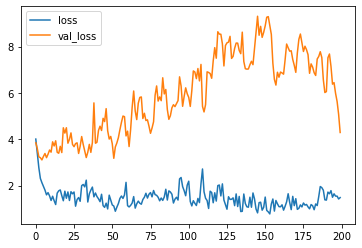

In [84]:
# Plot for loss

plt.plot(r_f_2.history['loss'], label='loss')
plt.plot(r_f_2.history['val_loss'], label='val_loss')
plt.legend()

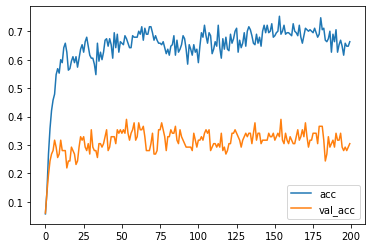

In [85]:
# plot for accuracy
plt.plot(r_f_2.history['accuracy'], label='acc')
plt.plot(r_f_2.history['val_accuracy'], label='val_acc')
plt.legend()

In [86]:
cvscores_fast_2 = []

In [87]:
for train, test in kfold.split(X):
    print(len(X[train]))
    print(len(Y[train][0]))

  # create model
    model = Sequential()
    e = Embedding(vocab_size, 300, weights=[embedding_matrix_fast], input_length=20, trainable=False)
    model.add(e)
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(len(training_class[0]), activation='softmax'))

# Compile model. Stochastic gradient descent with Nesterov accelerated gradient gives good results for this model
    adam = Adam(learning_rate=0.01)
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
# Fit the model
    model.fit(X[train], Y[train], epochs=200, batch_size=5, verbose=0)
# evaluate the model
    scores = model.evaluate(X[test], Y[test], verbose=0)
    model.summary()
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores_fast_2.append(scores[1] * 100)
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores_fast_2), numpy.std(cvscores_fast_2)))

217
49
Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_19 (Embedding)    (None, 20, 300)           67200     
                                                                 
 flatten_19 (Flatten)        (None, 6000)              0         
                                                                 
 dense_90 (Dense)            (None, 128)               768128    
                                                                 
 dropout_60 (Dropout)        (None, 128)               0         
                                                                 
 dense_91 (Dense)            (None, 64)                8256      
                                                                 
 dropout_61 (Dropout)        (None, 64)                0         
                                                                 
 dense_92 (Dense)            (None, 49)       